# AI Community @ Семинар № 9
## Поиск лиц на изображении

### Немного теории

#### Признаки Хаара [2]
Каждый признак проходит окном по изображению.  
На каждом шаге считается сумма интенсивностей пикселей под белой частью и сумма интенсивностей пикселей под черной частью.  
Получается два значения - для белой части и для черной. Затем, из первого значения вычитается второе.

![](./images/haar_features.png)

#### Пример

![](./images/feature_examples.png)

Этих признаков может быть очень много. Для окна размером 24 $\times$ 24 получается больше 160000 признаков [4].  
Получается, считать эти признаки будет очень долго. Для ускорения используют **Integral Image**[1], что позволяет считать сумму интенсивностей пикселей за константное время. Но это все равно медленно, так как признаков слишком много.  

#### AdaBoost

Для ускорения в оригинальной статье используют **AdaBoost** [0].  
Бустинг находит для каждого признака пороговое значение, при котором этот признак находит лицо на изображении.  
Затем, алгоритм выкидывает признаки, которые часто ошибаются. В конце у авторов статьи осталось около 6000 признаков.  
Также, по словам авторов, 200 признаков хватает для _95%_ точности.

#### Каскады

6000 признаков - все еще много, ведь нужно применить все эти признаки к каждому окну 24 $\times$ 24 на изображении.  
Решение - каскад признаков.  
На первом уровне вычисляется результат для одного признака в окне.  
  Если лица нет - переходим к следующему окну.  
  Если лицо есть - переходим к следующему уровню с другими признаками и тем же условием.  
Таким образом, если проходим по всем уровням до конца - нашли, что искали. Иначе - нет.

![](./images/flowchart.png)

Каскад в работе авторов состоит из 38 уровней, первые 5 уровней содержат 1, 10, 25, 25 и 50 признаков.  
Данная техника сильно ускоряет работу алгоритма: по словам авторов, в среднем для каждого окна считается всего 10 признаков из 6000.

---
### Практика
Применим обученные каскады при помощи OpenCV.

In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Загрузим обученные модели:

In [2]:
face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('cascades/haarcascade_eye.xml')

Тестовые изображения:

In [3]:
human = cv2.imread('images/human.png')[:,:,::-1]
people = cv2.imread('images/people.jpg')[:,:,::-1]
cat = cv2.imread('images/cat.jpg')[:,:,::-1]

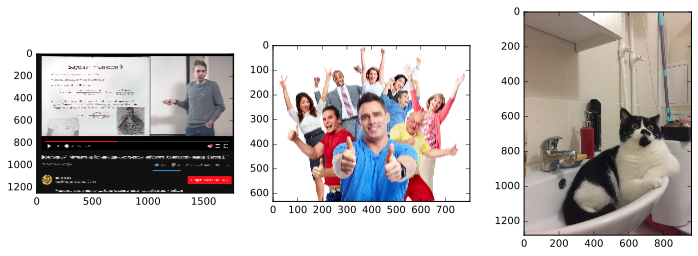

In [4]:
_, (left, center, right) = plt.subplots(ncols=3, figsize=(12, 4))
left.imshow(human)
center.imshow(people)
right.imshow(cat)
plt.show();

In [8]:
def plot_faces_eyes(image):
    """
    Метод ищет лица и глаза на изображении,
    и обводит их прямоугольниками.
    """
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = gray[y : y + h, x : x + w]
        roi_color = img[y : y + h, x : x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    return img

Посмотрим на примеры:

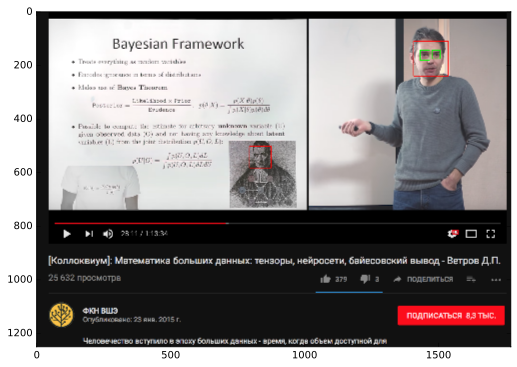

In [9]:
plt.figure(figsize=(17, 6))
plt.imshow(plot_faces_eyes(human));

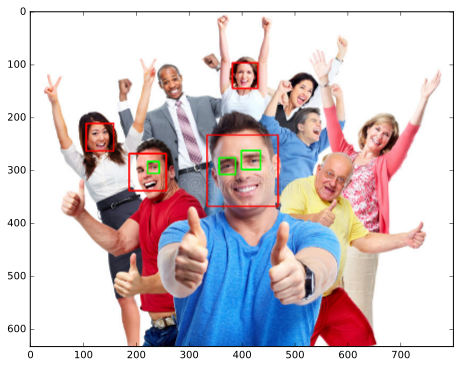

In [10]:
plt.figure(figsize=(17, 6))
plt.imshow(plot_faces_eyes(people));

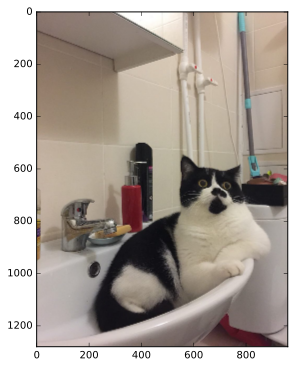

In [11]:
plt.figure(figsize=(17, 6))
plt.imshow(plot_faces_eyes(cat));

## Ссылки

0\. ["Rapid Object Detection using a Boosted Cascade of Simple Features"](http://wearables.cc.gatech.edu/paper_of_week/viola01rapid.pdf), 2011, Paul Viola and Michael Jones  
1\. [Integral image](https://en.wikipedia.org/wiki/Summed-area_table)  
2\. [Haar wavelets](https://en.wikipedia.org/wiki/Haar_wavelet)  
3\. [Demystifying Face Recognition](http://blcv.pl/static/tag/face-recogition/)  
4\. [Количество признаков](https://stackoverflow.com/questions/1707620/viola-jones-face-detection-claims-180k-features)  
5\. [Пример на Хабре](https://habrahabr.ru/post/198338/)